In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import wrf
from analysis_dependencies import get_wrf_slp
from analysis_dependencies import gen_cartopy_proj
from analysis_dependencies import get_wrf_kinematic
import datetime

In [2]:
# internal functions:
#
# haversine_np: compute the distance between 2 (lat,lon) points, or between
# a vector of (lat,lon) points and a single point. Uses great-circle distance
# estimated from Haversine function using the WRF's approximation of the Earth
# sphere to define radius.
#
# INPUTS:
#
# lat1: starting latitude (deg)
# lon1: starting longitude (deg)
# lat2: ending latitude (deg)
# lon2: ending longitude (deg)
#
# NOTE: either (lat1,lon1) can be a vector or array of points, or (lat2,lon2),
#       but not both. One of these sets has to be a scalar to compute the distance
#       to a single point for all points in the vector/array set.
#
# OUTPUTS:
#
# km: distance (km, assuming Earth is a sphere of 6370 km radius)
#
# DEPENDENCIES:
#
# numpy
def haversine_np(lat1, lon1, lat2, lon2):
    import numpy as np
    # assert all (lat,lon) values as radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # compute delta-(lat,lon) between points 1 and 2
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    # Haversine equation for unit sphere
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # scale to Earth approx. radius
    km = 6370 * c  # using same km radius as WRF earth-approximation
    return km

In [8]:
# define resolution subdirectory
res = '9km_res'
# define data directories
unpDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/Ida2021/R_mu/unperturbed/' + res + '/'
ptdDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/Ida2021/R_mu/negative/uvTq/upper_troposphere/ptdi13/' + res + '/'
# define initial datetime
dtInit = datetime.datetime(2021, 8, 28, 18)
# define forecast hour of interest
fcstHr = 24

In [9]:
# define forecast datetime
dtFcst = dtInit + datetime.timedelta(hours=fcstHr)
dtFcstStr = datetime.datetime.strftime(dtFcst,'%Y-%m-%d_%H:00:00')
# define unperturbed and perturbed wrfout file-names
unpFile = unpDir + 'wrfout_d01_' + dtFcstStr
ptdFile = ptdDir + 'wrfout_d01_' + dtFcstStr
# define netCDF4.Dataset() file-handles
unpHdl = Dataset(unpFile)
ptdHdl = Dataset(ptdFile)

In [10]:
# define latitude and longitude
lat = np.asarray(unpHdl.variables['XLAT']).squeeze()
lon = np.asarray(unpHdl.variables['XLONG']).squeeze()
fix = np.where(lon < 0.)
lon[fix] = lon[fix] + 360.
# define SLP field
unpSLP = np.asarray(get_wrf_slp(unpHdl)).squeeze()
ptdSLP = np.asarray(get_wrf_slp(ptdHdl)).squeeze()
# define DIV field
unpDIV = get_wrf_kinematic(unpHdl,'div')
ptdDIV = get_wrf_kinematic(ptdHdl,'div')

In [11]:
# define (j,i) of minimum SLP
# unperturbed
ji_min=np.unravel_index(np.argmin(unpSLP),np.shape(unpSLP))
ji_min=np.asarray(ji_min)
ju,iu = ji_min
print('j:',ju,'i:',iu,'slp:',unpSLP[ju,iu])
# perturbed
ji_min=np.unravel_index(np.argmin(ptdSLP),np.shape(ptdSLP))
ji_min=np.asarray(ji_min)
jp,ip = ji_min
print('j:',jp,'i:',ip,'slp:',ptdSLP[jp,ip])
# compute distance of all points from minimum SLP
unpCenDist = haversine_np(lat,lon,lat[ju,iu],lon[ju,iu])
ptdCenDist = haversine_np(lat,lon,lat[jp,ip],lon[jp,ip])

j: 124 i: 88 slp: 957.4164955036546
j: 122 i: 87 slp: 980.2483856075311


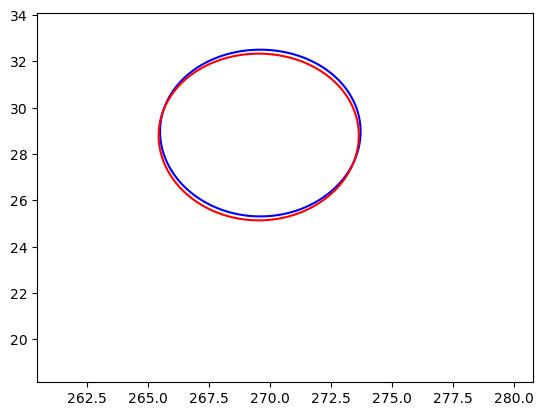

In [19]:
plt.contour(lon,lat,unpCenDist,levels=[400],colors='b')
plt.contour(lon,lat,ptdCenDist,levels=[400],colors='r')
plt.show()

In [17]:
# Compute divergence within 400 km radius of minimum SLP. This represents the
# radius over which a TC can extend its outflow in idealized simulation without
# the influence of its environment, per Ooyama 1987): numerical experiments of
# steady and transient jets with a simple model of the hurricane outflow, AMS
# 17th Conf. Tropical Meteor
#
# Any net divergence from this radius can be interpreted as outflow influenced
# by the environment.

radMin = 0.    # km
radMax = 400.  # km
unpInRad = np.where((unpCenDist.flatten() >= 0.) & (unpCenDist.flatten() <= 400.))
ptdInRad = np.where((ptdCenDist.flatten() >= 0.) & (ptdCenDist.flatten() <= 400.))
unpNetDiv = np.zeros((np.shape(unpDIV)[0],))
ptdNetDiv = np.zeros((np.shape(unpDIV)[0],))
for k in range(np.size(unpNetDiv)):
    div = np.asarray(unpDIV[k,:,:].squeeze())
    unpNetDiv[k] = np.sum(div.flatten()[unpInRad])
    div = np.asarray(ptdDIV[k,:,:].squeeze())
    ptdNetDiv[k] = np.sum(div.flatten()[ptdInRad])

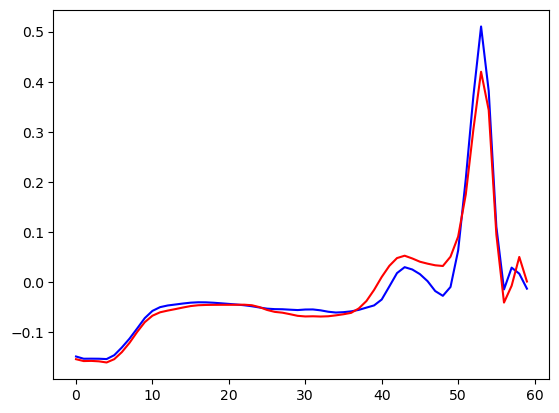

In [20]:
plt.plot(unpNetDiv,'b')
plt.plot(ptdNetDiv,'r')
plt.show()